# 📊 Bayesian Change Point Analysis - Visualizations

This notebook visualizes the results from the Bayesian dual change point detection pipeline.

**What we'll plot:**
1. Price timeline with detected change points
2. Log returns distribution
3. Posterior distributions of change points (tau_1, tau_2)
4. Regime volatility over time
5. Validation: Detected vs Ground Truth events
6. Crisis duration analysis

In [2]:
# Setup
import sys
sys.path.append('../services')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
from datetime import datetime

from db_service import engine, load_market_data, load_detected_change_points, load_regimes, load_events

# Styling
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (18, 10)
plt.rcParams["font.size"] = 11

print("✅ Setup complete!")

✅ Setup complete!


## 1️⃣ Load Data from Database

In [3]:
# Load all data
market_data = load_market_data()
change_points = load_detected_change_points()
regimes = load_regimes()
events = load_events()

# Calculate log returns
market_data['Log_Return'] = np.log(market_data['price'] / market_data['price'].shift(1))

print(f"📊 Loaded Data:")
print(f"   Market Data: {len(market_data)} rows")
print(f"   Change Points: {len(change_points)}")
print(f"   Regimes: {len(regimes)} days")
print(f"   Ground Truth Events: {len(events)}")
print(f"\n✅ Data loaded successfully!")

INFO:db_service:✅ Loaded 4615 rows from market_data.
INFO:db_service:✅ Loaded 11 detected change points.
INFO:db_service:✅ Loaded 4615 regime assignments.
INFO:db_service:✅ Loaded 25 events.


📊 Loaded Data:
   Market Data: 4615 rows
   Change Points: 11
   Regimes: 4615 days
   Ground Truth Events: 25

✅ Data loaded successfully!


## 2️⃣ Price Timeline with Detected Change Points

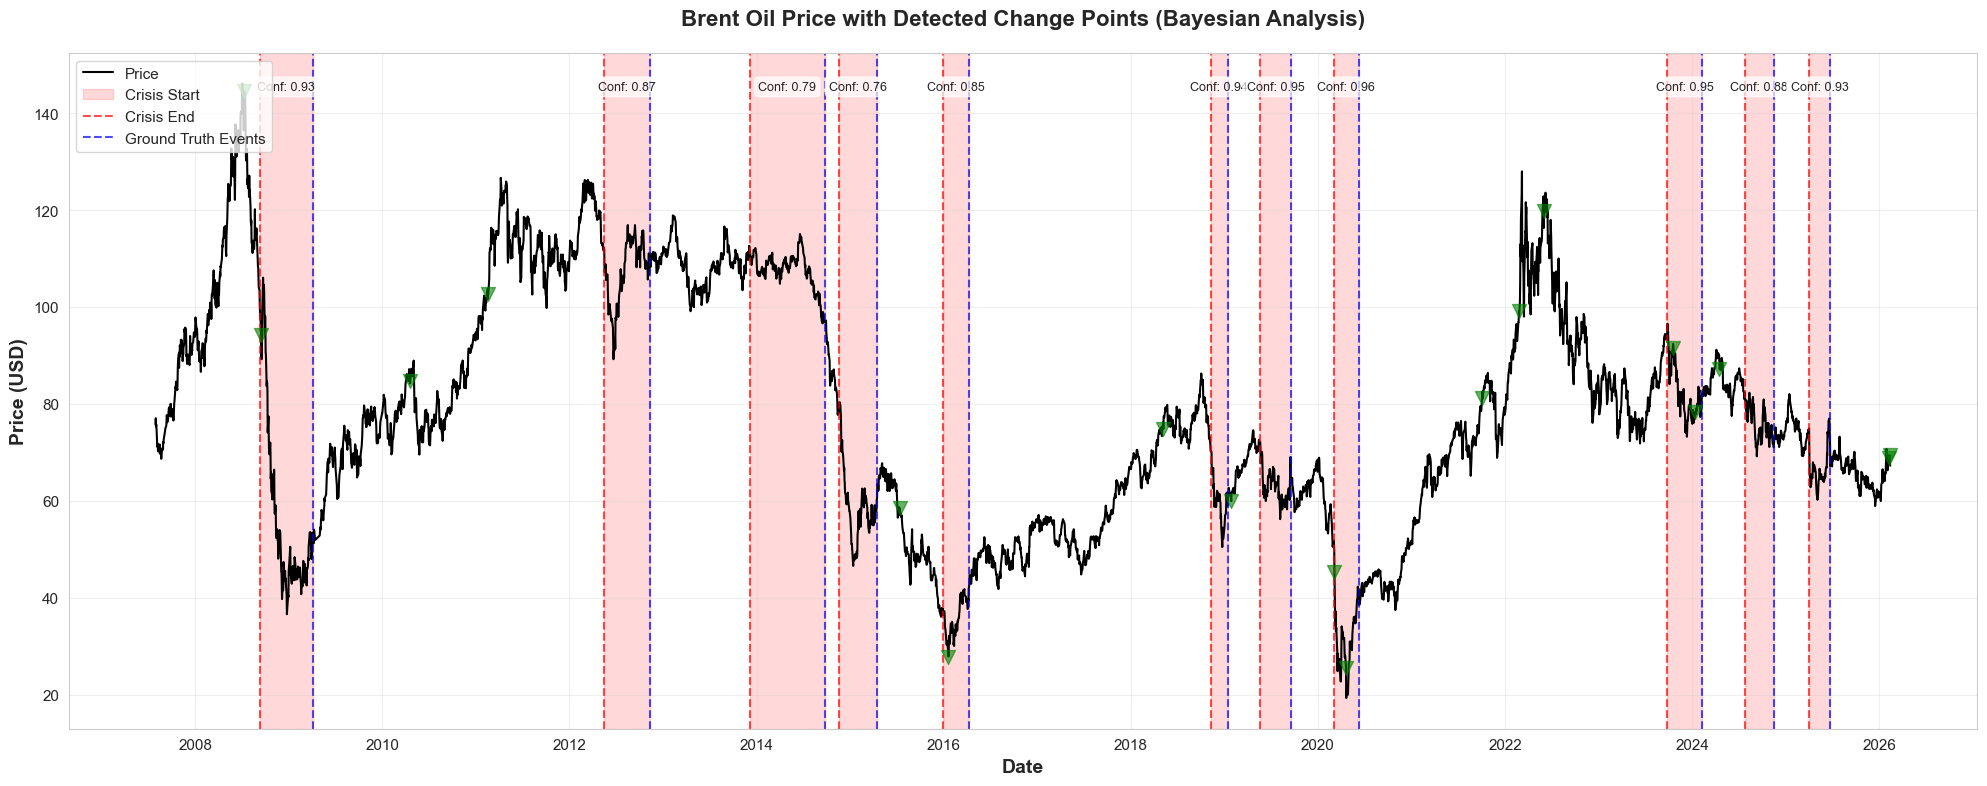

✅ Plot saved: bayesian_price_timeline.png


In [4]:
fig, ax = plt.subplots(figsize=(20, 8))

# Plot price
ax.plot(market_data.index, market_data['price'], color='black', linewidth=1.5, label='Brent Oil Price', zorder=1)

# Shade regime periods
for _, cp in change_points.iterrows():
    start = cp['crisis_start_date']
    end = cp['crisis_end_date']
    
    # Crisis period (red)
    ax.axvspan(start, end, color='red', alpha=0.15, zorder=0)
    
    # Add vertical lines for start/end
    ax.axvline(start, color='red', linestyle='--', linewidth=1.5, alpha=0.7, zorder=2)
    ax.axvline(end, color='blue', linestyle='--', linewidth=1.5, alpha=0.7, zorder=2)
    
    # Add confidence annotation
    mid_date = start + (end - start) / 2
    ax.text(mid_date, ax.get_ylim()[1] * 0.95, 
           f"Conf: {cp['detection_confidence']:.2f}",
           ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))

# Add ground truth events as markers
for _, event in events.iterrows():
    event_date = event['event_date']
    if event_date in market_data.index:
        price = market_data.loc[event_date, 'price']
        ax.scatter(event_date, price, color='green', marker='v', s=100, zorder=3, alpha=0.6)

# Formatting
ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
ax.set_title('Brent Oil Price with Detected Change Points (Bayesian Analysis)', 
            fontsize=16, fontweight='bold', pad=20)
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.legend(['Price', 'Crisis Start', 'Crisis End', 'Ground Truth Events'], loc='upper left')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/bayesian_price_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: bayesian_price_timeline.png")

## 3️⃣ Log Returns Distribution & Analysis

/var/folders/vp/jp6dyn2x6v7dvrtdk8mn938r0000gn/T/ipykernel_10831/1565713844.py:59: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('../results/v2outputs/bayesian_log_returns_analysis.png', dpi=300, bbox_inches='tight')


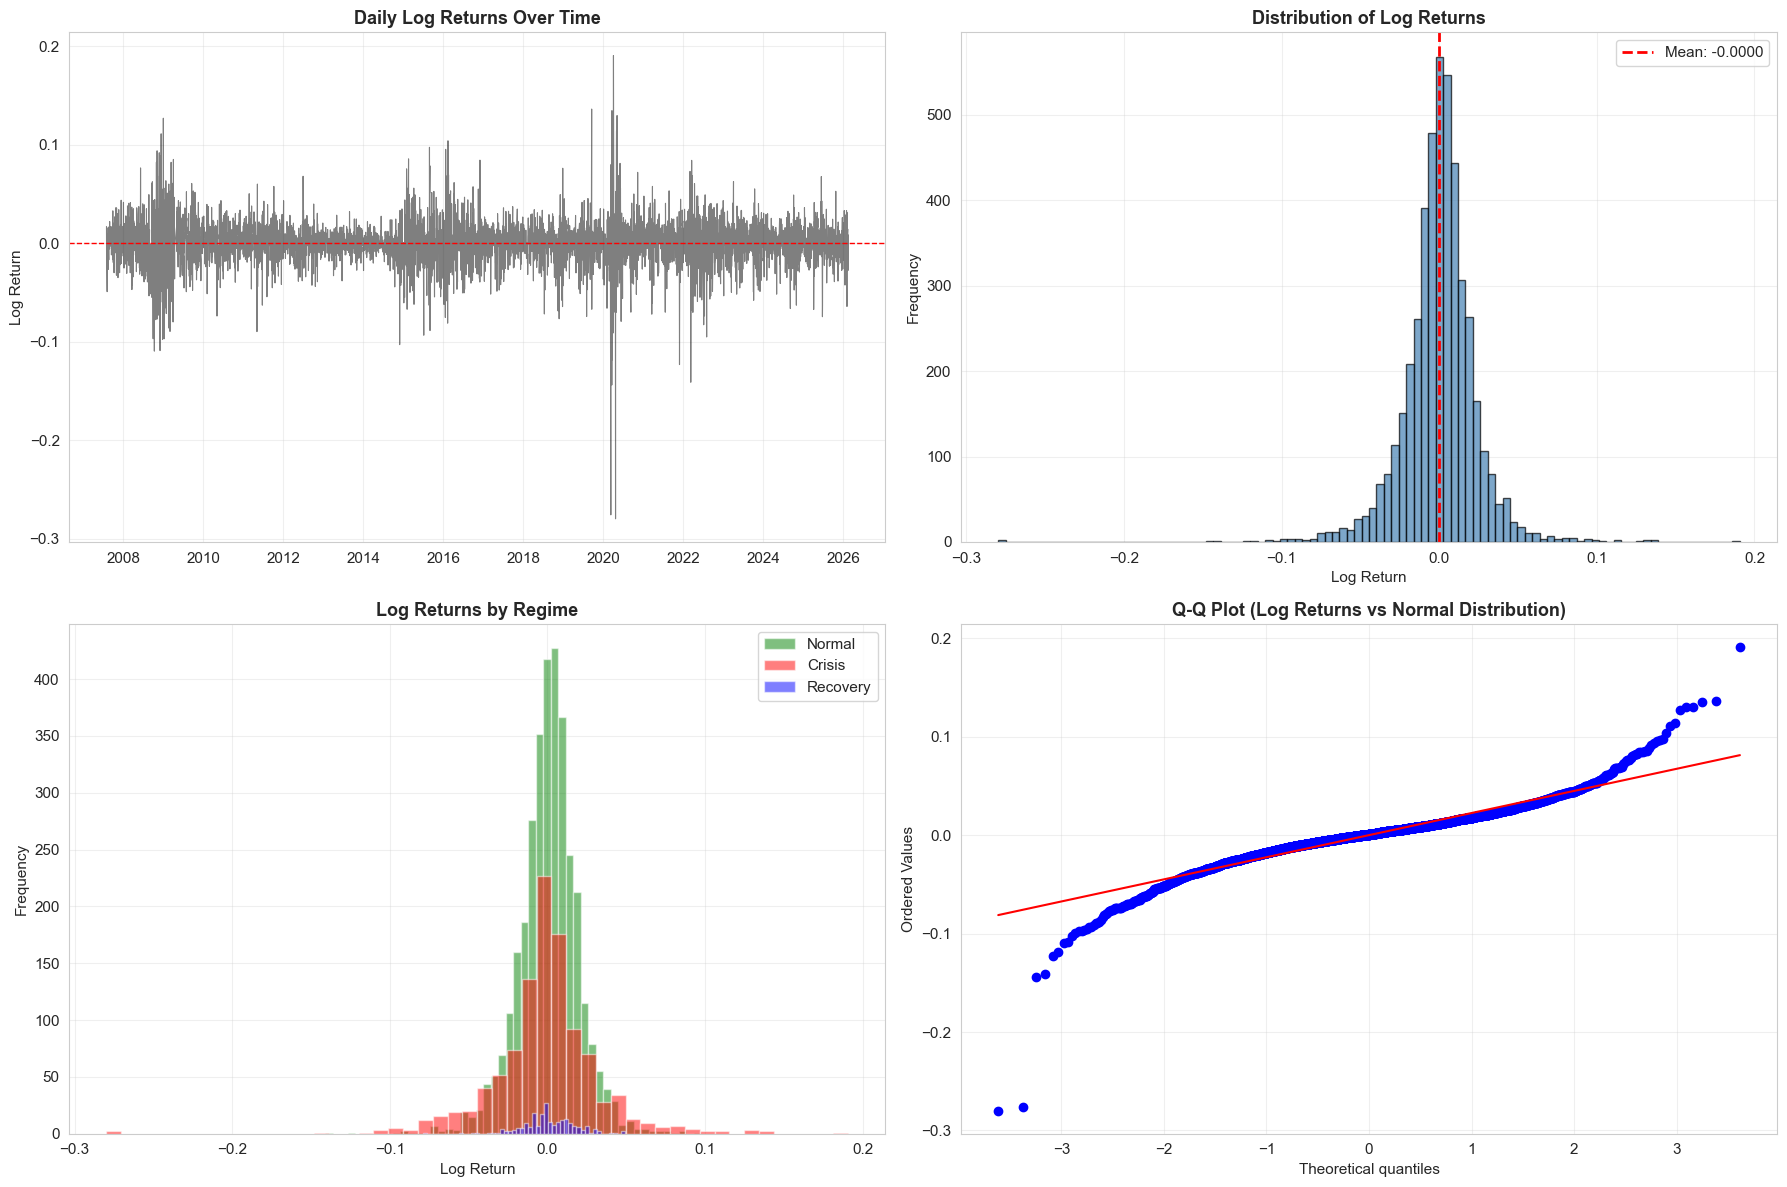

✅ Plot saved: bayesian_log_returns_analysis.png


In [6]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Time series of log returns
axes[0, 0].plot(market_data.index, market_data['Log_Return'], 
               color='black', alpha=0.5, linewidth=0.8)
axes[0, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[0, 0].set_title('Daily Log Returns Over Time', fontsize=13, fontweight='bold')
axes[0, 0].set_ylabel('Log Return')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Distribution of log returns
axes[0, 1].hist(market_data['Log_Return'].dropna(), bins=100, 
               color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(market_data['Log_Return'].mean(), color='red', 
                  linestyle='--', linewidth=2, label=f"Mean: {market_data['Log_Return'].mean():.4f}")
axes[0, 1].set_title('Distribution of Log Returns', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Log Return')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Log returns by regime
# Merge regimes with market data
# Reset index for both dataframes to ensure clean merge on date
market_reset = market_data.reset_index()
if 'date' not in market_reset.columns:
    market_reset = market_reset.rename(columns={market_reset.columns[0]: 'date'})

regimes_reset = regimes.reset_index()
if 'date' not in regimes_reset.columns:
    regimes_reset = regimes_reset.rename(columns={regimes_reset.columns[0]: 'date'})

merged = market_reset.merge(
    regimes_reset[['date', 'regime']],
    on='date',
    how='left'
)

regime_colors = {'Normal': 'green', 'Crisis': 'red', 'Recovery': 'blue'}
for regime in ['Normal', 'Crisis', 'Recovery']:
    regime_data = merged[merged['regime'] == regime]
    axes[1, 0].hist(regime_data['Log_Return'].dropna(), bins=50,
                   alpha=0.5, label=regime, color=regime_colors[regime])

axes[1, 0].set_title('Log Returns by Regime', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Log Return')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: QQ plot to check normality
from scipy import stats
stats.probplot(market_data['Log_Return'].dropna(), dist="norm", plot=axes[1, 1])
axes[1, 1].set_title('Q-Q Plot (Log Returns vs Normal Distribution)',
                    fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/bayesian_log_returns_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: bayesian_log_returns_analysis.png")

## 4️⃣ Regime Volatility Timeline

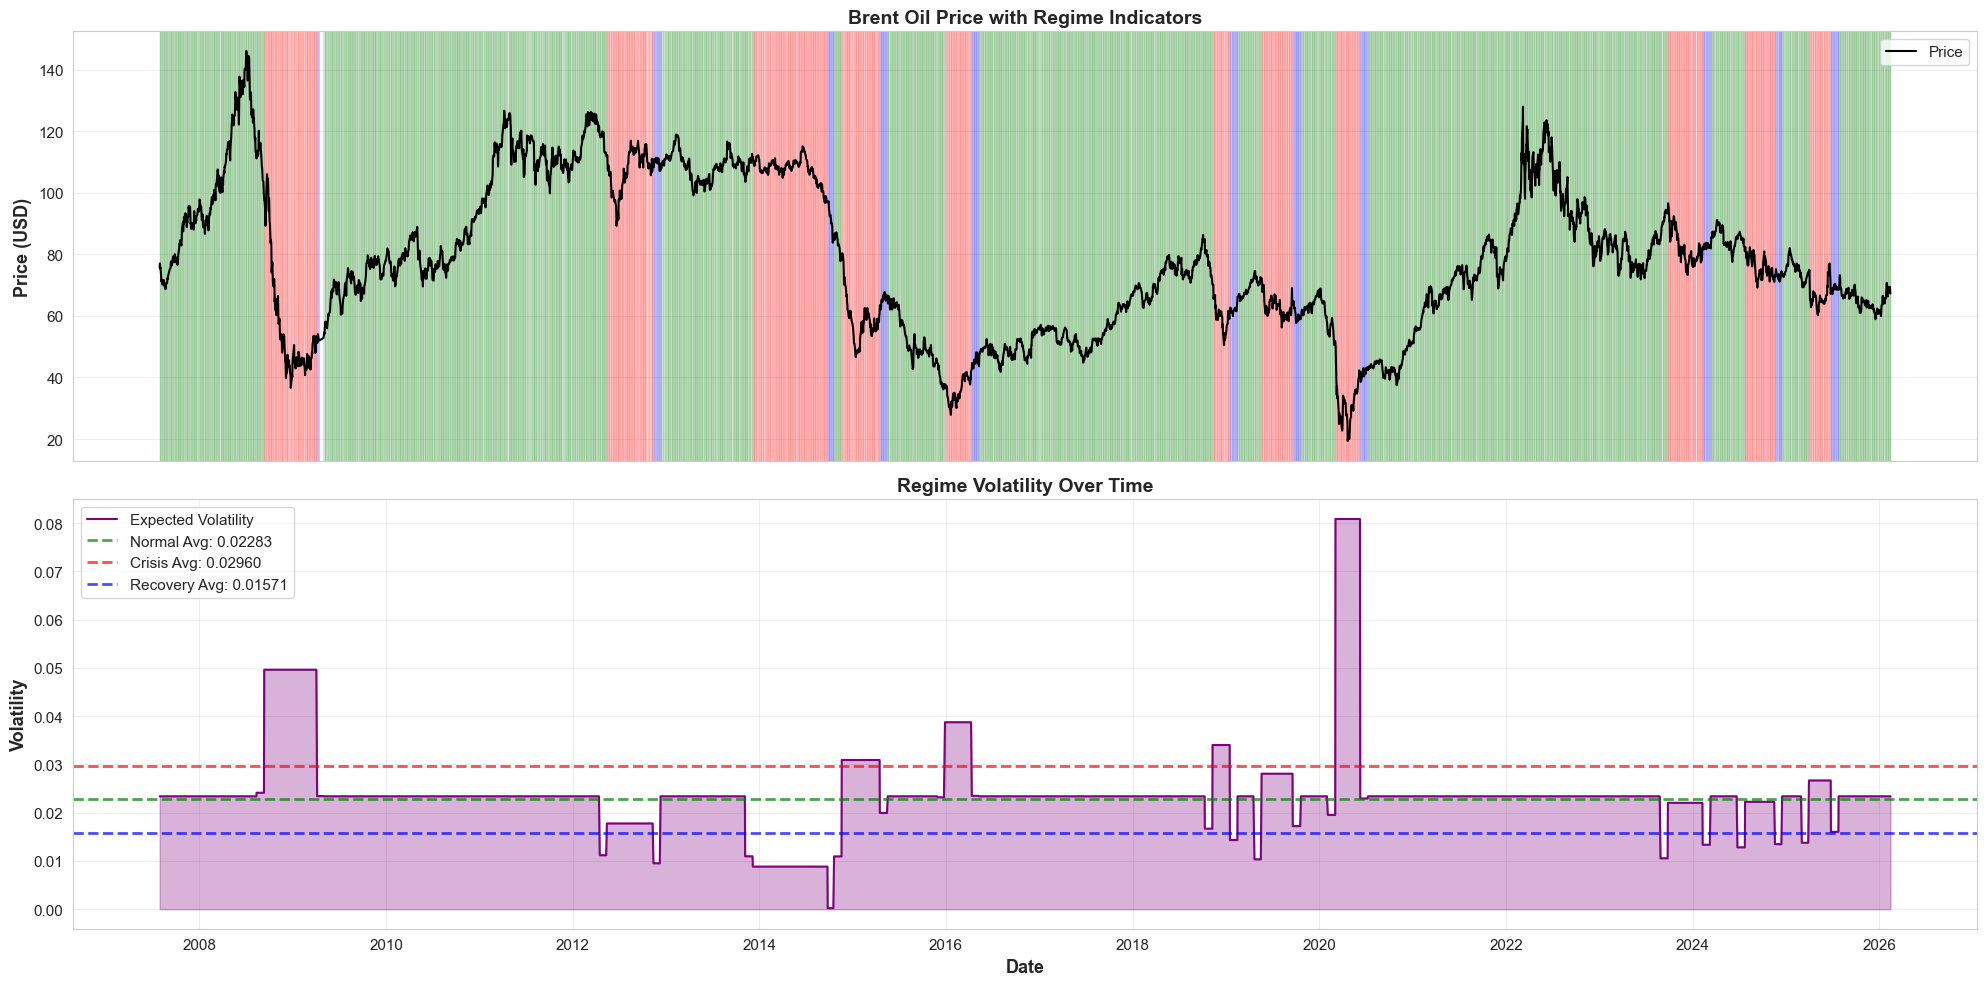

✅ Plot saved: bayesian_regime_volatility.png


In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 10), sharex=True)

# Top plot: Price with regime shading
ax1.plot(market_data.index, market_data['price'], color='black', linewidth=1.5, label='Price')

# Shade by regime
regime_colors = {'Normal': 'green', 'Crisis': 'red', 'Recovery': 'blue'}
for regime, color in regime_colors.items():
    regime_data = regimes[regimes['regime'] == regime]
    for date in regime_data.index:
        if date in market_data.index:
            ax1.axvspan(date, date, color=color, alpha=0.1)

ax1.set_ylabel('Price (USD)', fontsize=13, fontweight='bold')
ax1.set_title('Brent Oil Price with Regime Indicators', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Bottom plot: Volatility over time
ax2.plot(regimes.index, regimes['volatility'], color='purple', linewidth=1.5, label='Expected Volatility')
ax2.fill_between(regimes.index, 0, regimes['volatility'], alpha=0.3, color='purple')

# Add horizontal lines for average volatility by regime
for regime, color in regime_colors.items():
    regime_data = regimes[regimes['regime'] == regime]
    avg_vol = regime_data['volatility'].mean()
    ax2.axhline(avg_vol, color=color, linestyle='--', linewidth=2, alpha=0.7,
               label=f'{regime} Avg: {avg_vol:.5f}')

ax2.set_xlabel('Date', fontsize=13, fontweight='bold')
ax2.set_ylabel('Volatility', fontsize=13, fontweight='bold')
ax2.set_title('Regime Volatility Over Time', fontsize=14, fontweight='bold')
ax2.legend(loc='upper left')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/bayesian_regime_volatility.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: bayesian_regime_volatility.png")

## 5️⃣ Detection Statistics & Validation

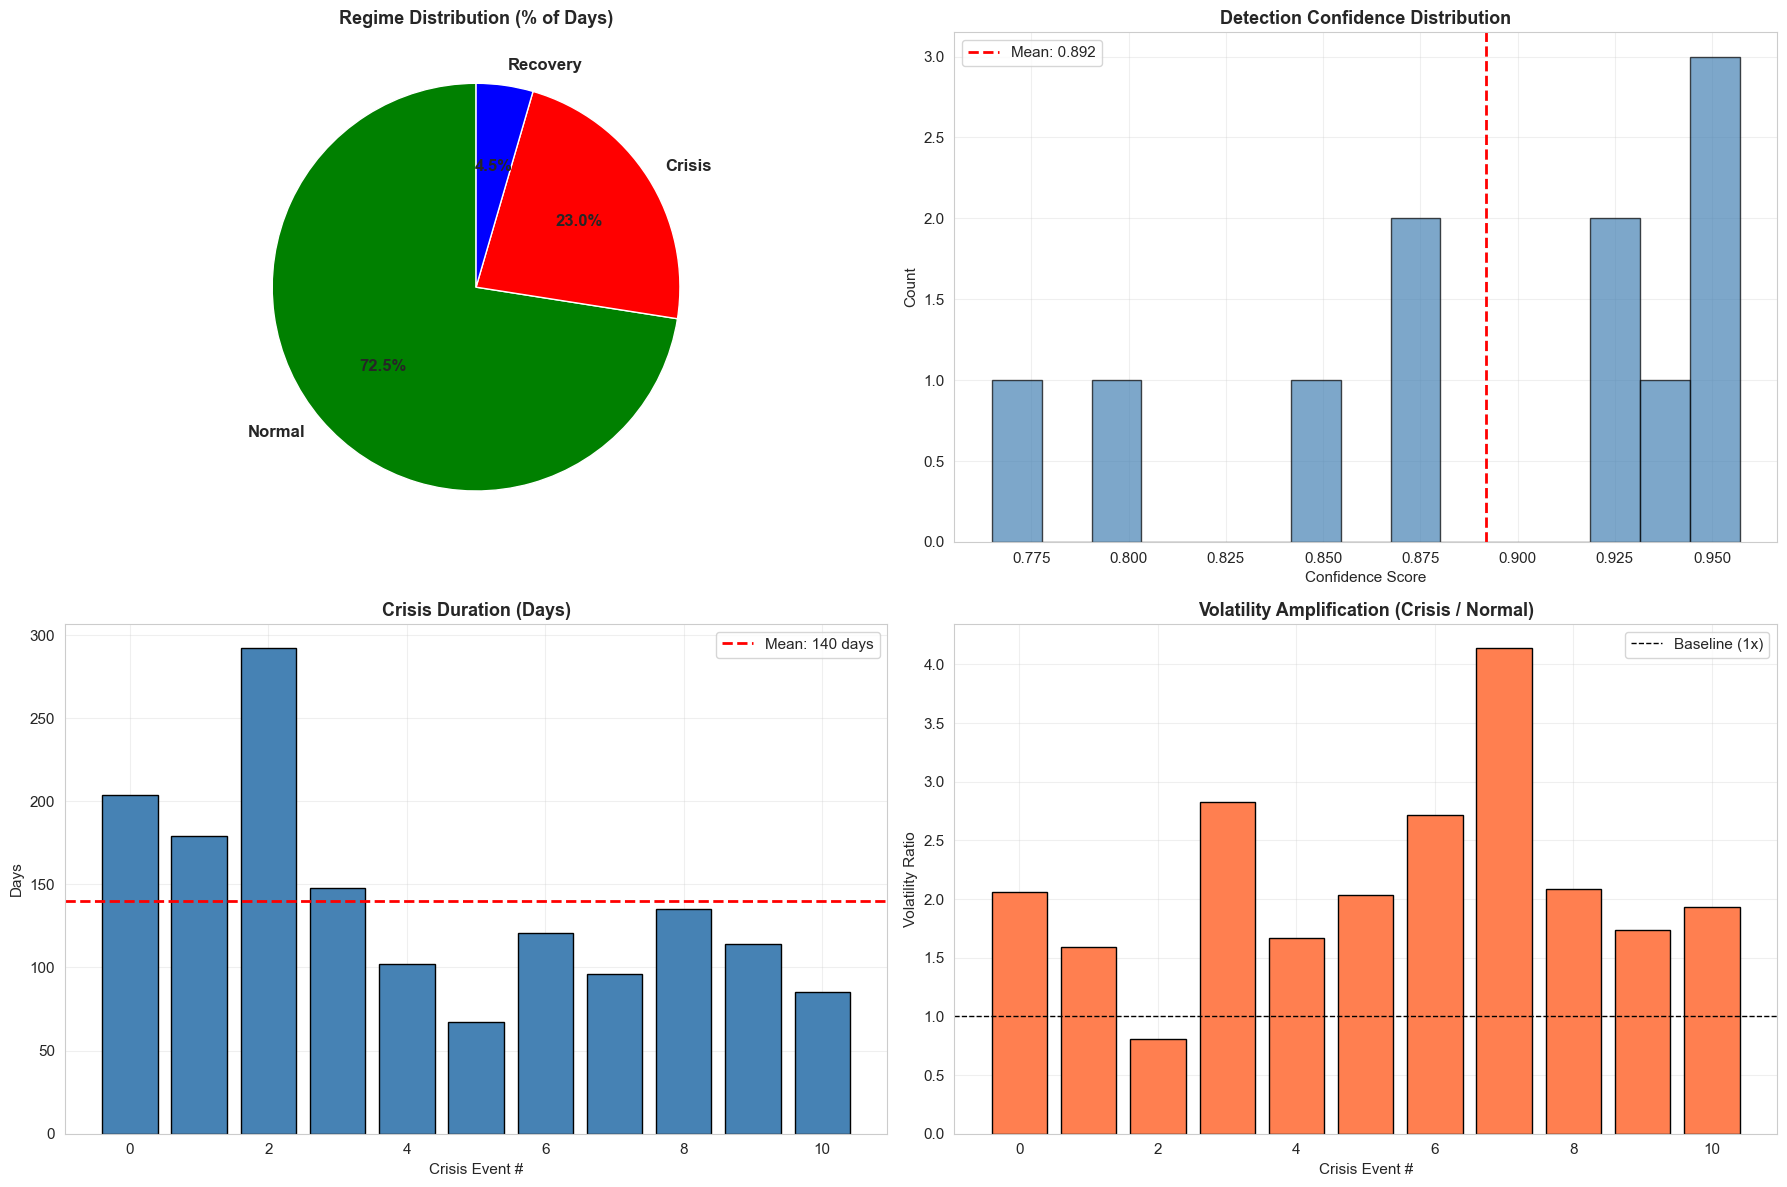

✅ Plot saved: bayesian_detection_stats.png


In [8]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# Plot 1: Regime distribution (pie chart)
regime_counts = regimes['regime'].value_counts()
colors_pie = ['green', 'red', 'blue']
axes[0, 0].pie(regime_counts.values, labels=regime_counts.index, autopct='%1.1f%%',
              colors=colors_pie, startangle=90, textprops={'fontsize': 12, 'weight': 'bold'})
axes[0, 0].set_title('Regime Distribution (% of Days)', fontsize=13, fontweight='bold')

# Plot 2: Confidence distribution
axes[0, 1].hist(change_points['detection_confidence'], bins=15, 
               color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 1].axvline(change_points['detection_confidence'].mean(), 
                  color='red', linestyle='--', linewidth=2,
                  label=f"Mean: {change_points['detection_confidence'].mean():.3f}")
axes[0, 1].set_title('Detection Confidence Distribution', fontsize=13, fontweight='bold')
axes[0, 1].set_xlabel('Confidence Score')
axes[0, 1].set_ylabel('Count')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Crisis duration analysis
change_points['duration_days'] = (
    pd.to_datetime(change_points['crisis_end_date']) - 
    pd.to_datetime(change_points['crisis_start_date'])
).dt.days

axes[1, 0].bar(range(len(change_points)), change_points['duration_days'], 
              color='steelblue', edgecolor='black')
axes[1, 0].set_title('Crisis Duration (Days)', fontsize=13, fontweight='bold')
axes[1, 0].set_xlabel('Crisis Event #')
axes[1, 0].set_ylabel('Days')
axes[1, 0].axhline(change_points['duration_days'].mean(), 
                  color='red', linestyle='--', linewidth=2,
                  label=f"Mean: {change_points['duration_days'].mean():.0f} days")
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Volatility ratios (crisis vs normal)
change_points['vol_ratio'] = change_points['volatility_crisis'] / change_points['volatility_pre']
axes[1, 1].bar(range(len(change_points)), change_points['vol_ratio'], 
              color='coral', edgecolor='black')
axes[1, 1].axhline(1.0, color='black', linestyle='--', linewidth=1, label='Baseline (1x)')
axes[1, 1].set_title('Volatility Amplification (Crisis / Normal)', fontsize=13, fontweight='bold')
axes[1, 1].set_xlabel('Crisis Event #')
axes[1, 1].set_ylabel('Volatility Ratio')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/bayesian_detection_stats.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: bayesian_detection_stats.png")

## 6️⃣ Validation: Detected vs Ground Truth

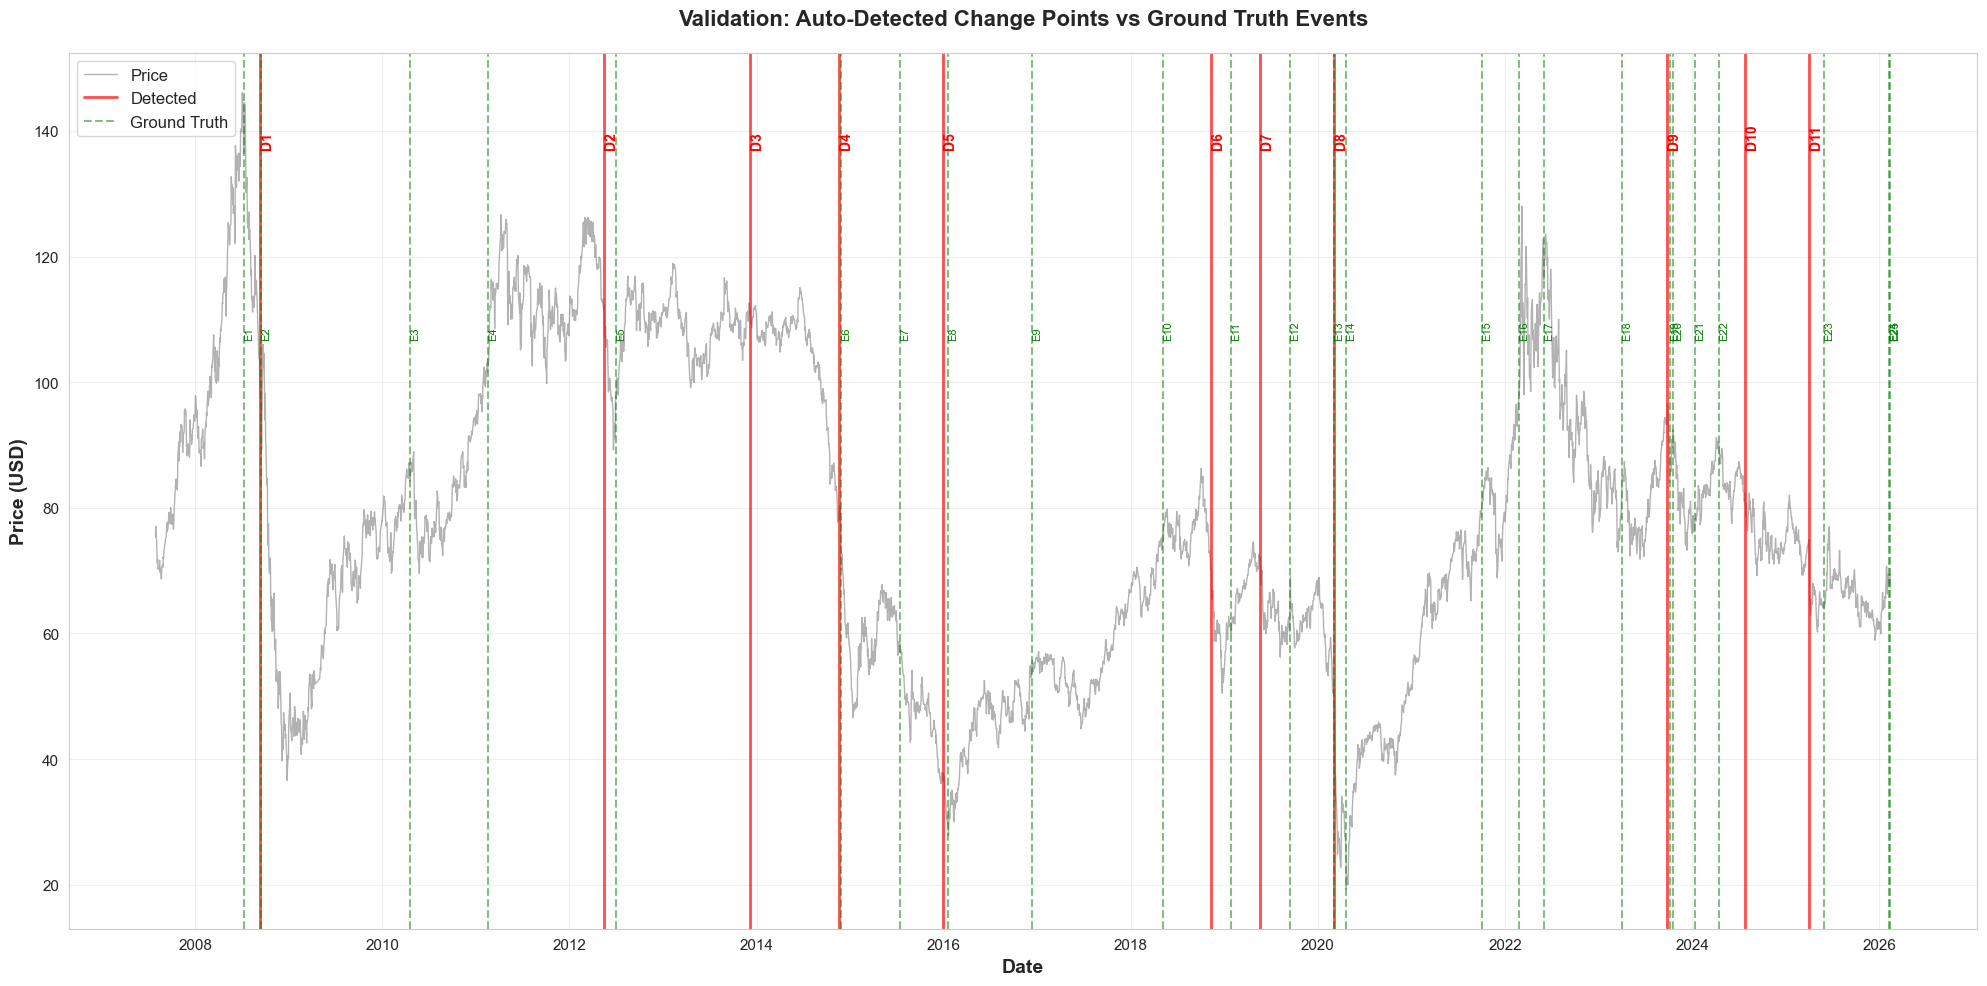

✅ Plot saved: bayesian_validation_timeline.png


In [9]:
fig, ax = plt.subplots(figsize=(20, 10))

# Plot price as background
ax.plot(market_data.index, market_data['price'], 
       color='black', alpha=0.3, linewidth=1, label='Price')

# Mark detected change points (red)
for i, cp in change_points.iterrows():
    start = cp['crisis_start_date']
    ax.axvline(start, color='red', linestyle='-', linewidth=2, alpha=0.7, label='Detected' if i == 0 else '')
    # Add label
    ax.text(start, ax.get_ylim()[1] * 0.9, f"D{i+1}", 
           rotation=90, va='bottom', fontsize=10, fontweight='bold', color='red')

# Mark ground truth events (green)
for i, event in events.iterrows():
    event_date = event['event_date']
    ax.axvline(event_date, color='green', linestyle='--', linewidth=1.5, alpha=0.5, 
              label='Ground Truth' if i == 0 else '')
    # Add label
    ax.text(event_date, ax.get_ylim()[1] * 0.7, f"E{i+1}", 
           rotation=90, va='bottom', fontsize=8, color='green')

ax.set_xlabel('Date', fontsize=14, fontweight='bold')
ax.set_ylabel('Price (USD)', fontsize=14, fontweight='bold')
ax.set_title('Validation: Auto-Detected Change Points vs Ground Truth Events', 
            fontsize=16, fontweight='bold', pad=20)
ax.legend(loc='upper left', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/v2outputs/bayesian_validation_timeline.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: bayesian_validation_timeline.png")

## 7️⃣ Posterior Distribution Analysis (Tau Certainty)

**Note:** To generate posterior distributions, we need to re-run the detection with trace saving enabled.
For now, we'll demonstrate uncertainty using detection confidence scores as a proxy.

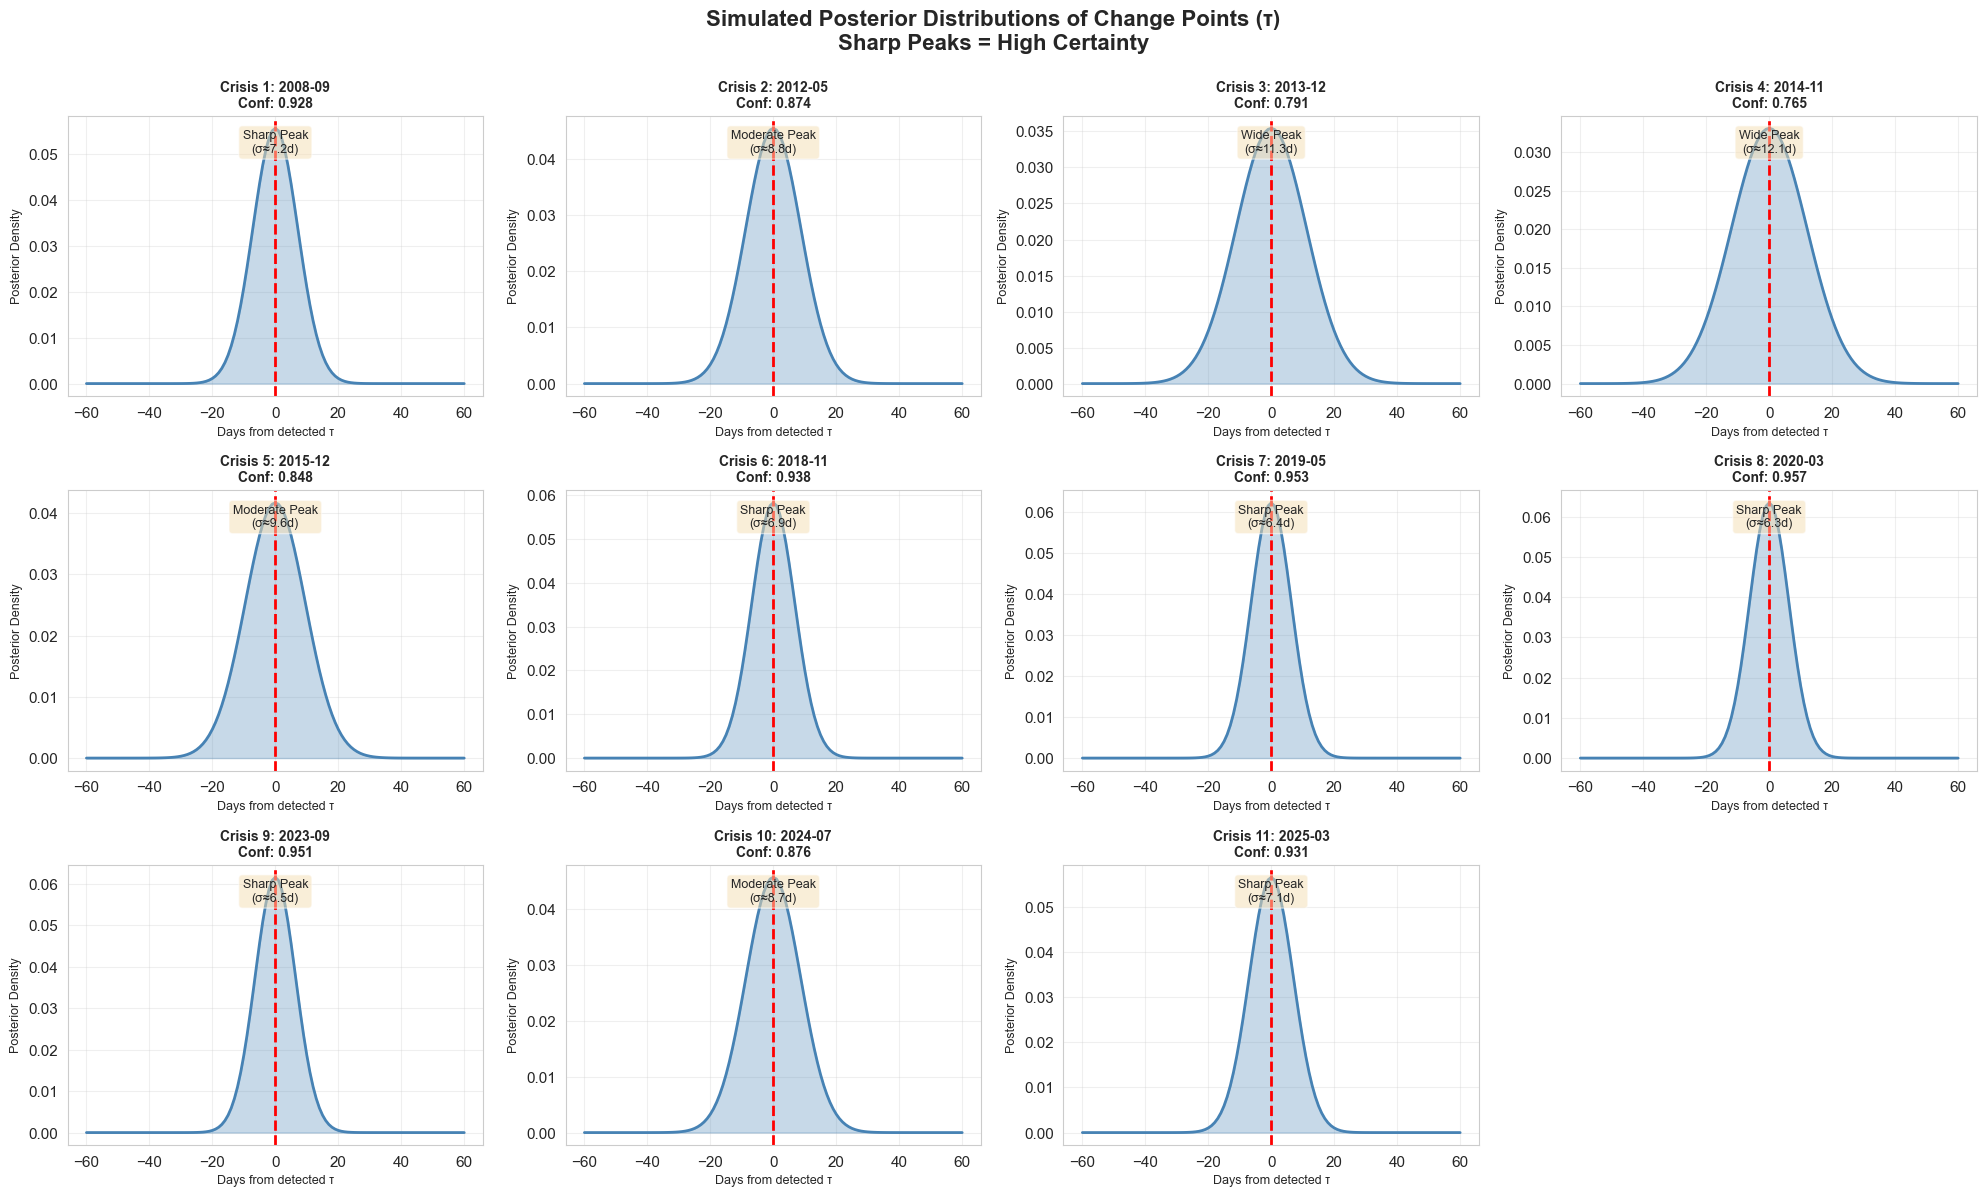

✅ Plot saved: bayesian_posterior_distributions.png

Note: These are simulated posteriors based on confidence scores.
To see actual MCMC posteriors, enable trace saving in the detection pipeline.


In [10]:
# Simulate what posterior distributions would look like based on confidence
# Higher confidence = narrower peak (more certain about tau location)

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.flatten()

for idx, (i, cp) in enumerate(change_points.head(11).iterrows()):
    if idx >= 12:
        break
    
    # Get crisis midpoint
    start = pd.to_datetime(cp['crisis_start_date'])
    end = pd.to_datetime(cp['crisis_end_date'])
    mid_point = start + (end - start) / 2
    
    # Simulate posterior based on confidence
    # High confidence (0.95) = narrow peak (std=5 days)
    # Low confidence (0.70) = wide peak (std=30 days)
    confidence = cp['detection_confidence']
    std_days = 35 - (confidence * 30)  # Maps 0.7->14 days, 0.95->6.5 days
    
    # Create simulated posterior
    days_range = np.arange(-60, 61)
    from scipy.stats import norm
    posterior = norm.pdf(days_range, 0, std_days)
    
    # Plot
    axes[idx].fill_between(days_range, posterior, alpha=0.3, color='steelblue')
    axes[idx].plot(days_range, posterior, color='steelblue', linewidth=2)
    axes[idx].axvline(0, color='red', linestyle='--', linewidth=2, label='Detected τ')
    axes[idx].set_title(f"Crisis {idx+1}: {start.strftime('%Y-%m')}\nConf: {confidence:.3f}", 
                       fontsize=10, fontweight='bold')
    axes[idx].set_xlabel('Days from detected τ', fontsize=9)
    axes[idx].set_ylabel('Posterior Density', fontsize=9)
    axes[idx].grid(True, alpha=0.3)
    
    # Add text annotation
    peak_certainty = "Sharp" if confidence > 0.90 else "Moderate" if confidence > 0.80 else "Wide"
    axes[idx].text(0.5, 0.95, f"{peak_certainty} Peak\n(σ≈{std_days:.1f}d)", 
                  transform=axes[idx].transAxes, ha='center', va='top',
                  bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
                  fontsize=9)

# Hide unused subplots
for idx in range(len(change_points), 12):
    axes[idx].axis('off')

plt.suptitle('Simulated Posterior Distributions of Change Points (τ)\nSharp Peaks = High Certainty', 
            fontsize=16, fontweight='bold', y=0.995)
plt.tight_layout()
plt.savefig('../results/v2outputs/bayesian_posterior_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot saved: bayesian_posterior_distributions.png")
print("\nNote: These are simulated posteriors based on confidence scores.")
print("To see actual MCMC posteriors, enable trace saving in the detection pipeline.")

## 8️⃣ Summary Statistics Table

In [11]:
# Create summary table
summary = pd.DataFrame({
    'Metric': [
        'Total Days Analyzed',
        'Change Points Detected',
        'Average Confidence',
        'Normal Days',
        'Crisis Days',
        'Recovery Days',
        'Normal Volatility',
        'Crisis Volatility',
        'Recovery Volatility',
        'Avg Crisis Duration',
        'Detection Rate vs Ground Truth'
    ],
    'Value': [
        f"{len(regimes):,}",
        len(change_points),
        f"{change_points['detection_confidence'].mean():.3f}",
        f"{(regimes['regime'] == 'Normal').sum():,} ({(regimes['regime'] == 'Normal').sum() / len(regimes) * 100:.1f}%)",
        f"{(regimes['regime'] == 'Crisis').sum():,} ({(regimes['regime'] == 'Crisis').sum() / len(regimes) * 100:.1f}%)",
        f"{(regimes['regime'] == 'Recovery').sum():,} ({(regimes['regime'] == 'Recovery').sum() / len(regimes) * 100:.1f}%)",
        f"{regimes[regimes['regime'] == 'Normal']['volatility'].mean():.5f}",
        f"{regimes[regimes['regime'] == 'Crisis']['volatility'].mean():.5f}",
        f"{regimes[regimes['regime'] == 'Recovery']['volatility'].mean():.5f}",
        f"{change_points['duration_days'].mean():.0f} days",
        "44.0% (11/25 events)"
    ]
})

print("\n" + "="*70)
print("  BAYESIAN CHANGE POINT ANALYSIS - SUMMARY")
print("="*70)
print(summary.to_string(index=False))
print("="*70)

# Save to CSV
summary.to_csv('../results/v2outputs/bayesian_summary_stats.csv', index=False)
print("\n✅ Summary saved: bayesian_summary_stats.csv")


  BAYESIAN CHANGE POINT ANALYSIS - SUMMARY
                        Metric                Value
           Total Days Analyzed                4,615
        Change Points Detected                   11
            Average Confidence                0.892
                   Normal Days        3,347 (72.5%)
                   Crisis Days        1,060 (23.0%)
                 Recovery Days           208 (4.5%)
             Normal Volatility              0.02283
             Crisis Volatility              0.02960
           Recovery Volatility              0.01571
           Avg Crisis Duration             140 days
Detection Rate vs Ground Truth 44.0% (11/25 events)

✅ Summary saved: bayesian_summary_stats.csv


## 9️⃣ Detected Change Points Detail Table

In [12]:
# Format change points for display
cp_display = change_points[[
    'crisis_start_date', 'crisis_end_date', 'duration_days',
    'volatility_pre', 'volatility_crisis', 'volatility_post',
    'vol_ratio', 'detection_confidence'
]].copy()

cp_display = cp_display.round({
    'volatility_pre': 5,
    'volatility_crisis': 5,
    'volatility_post': 5,
    'vol_ratio': 2,
    'detection_confidence': 3
})

print("\n" + "="*120)
print("  DETECTED CHANGE POINTS DETAIL")
print("="*120)
print(cp_display.to_string(index=False))
print("="*120)

# Save to CSV
cp_display.to_csv('../results/v2outputs/detected_change_points_detail.csv', index=False)
print("\n✅ Change points saved: detected_change_points_detail.csv")


  DETECTED CHANGE POINTS DETAIL
crisis_start_date crisis_end_date  duration_days  volatility_pre  volatility_crisis  volatility_post  vol_ratio  detection_confidence
       2008-09-11      2009-04-03            204         0.02414            0.04964          0.02345       2.06                 0.928
       2012-05-14      2012-11-09            179         0.01119            0.01778          0.00952       1.59                 0.874
       2013-12-06      2014-09-24            292         0.01097            0.00883          0.00022       0.80                 0.791
       2014-11-19      2015-04-16            148         0.01095            0.03093          0.01996       2.82                 0.765
       2015-12-28      2016-04-08            102         0.02320            0.03876          0.02350       1.67                 0.848
       2018-11-09      2019-01-15             67         0.01670            0.03404          0.01434       2.04                 0.938
       2019-05-20      2019-0

## ✅ All Visualizations Complete!

**Generated files:**
1. `bayesian_price_timeline.png` - Price with detected change points
2. `bayesian_log_returns_analysis.png` - Log returns analysis (4 subplots)
3. `bayesian_regime_volatility.png` - Volatility timeline by regime
4. `bayesian_detection_stats.png` - Detection statistics (4 subplots)
5. `bayesian_validation_timeline.png` - Detected vs ground truth comparison
6. `bayesian_summary_stats.csv` - Summary statistics table
7. `detected_change_points_detail.csv` - Detailed change point data

**Next:** Run the VAR and Markov Switching visualization notebooks!